In [1]:
# imports
from hnn_core import (simulate_dipole, law_2021_model, calcium_model, jones_2009_model,
                     read_dipole, read_params, MPIBackend, JoblibBackend,
                     average_dipoles)
from hnn_core.viz import plot_dipole
from hnn_core.cells_default import pyramidal
from functools import partial

import numpy as np

#from hnn_core.network_models import diesburg_2024_model

import matplotlib.pyplot as plt

Below is a set of functions that create an hnn-core network that replicates the changes made to the default from Diesburg et al., 2024. In addition, the changes from Law needed to elicit the GABAb-ergic inhibitory effects of the Law model have been added. Eventually this will be programmed into hnn-core, but for now is standalone outside the hnn-core code.

In [2]:
# helper functions
def _short_name(short_name):
    long_name = dict(L2_basket='L2Basket', L5_basket='L5Basket',
                     L2_pyramidal='L2Pyr', L5_pyramidal='L5Pyr')
    if short_name in long_name:
        return long_name[short_name]
    return short_name

def _linear_g_at_dist(x, gsoma, gdend, xkink):
    """Compute linear distance-dependent ionic conductance.

    Parameters
    ----------
    x : float | int
        Distance from soma
    gsoma : float | int
        Somatic conductance.
    gdend : float | int
        Dendritic conductance
    xkink : float | int
        Plateau value where conductance is fixed at gdend.

    Notes
    -----
    Linearly scales conductance along dendrite.
    Returns gdend when x > xkink.
    """
    return gsoma + np.min([xkink, x]) * (gdend - gsoma) / xkink

def _exp_g_at_dist(x, zero_val, exp_term, offset):
    """Compute exponential distance-dependent ionic conductance.

    Parameters
    ----------
    x : float | int
        Distance from soma
    zero_val : float | int
        Value of function when x = 0
    exp_term : float | int
        Mutiplier of x in the exponent
    offset: float |int
        Offset value added to output

    """

    return zero_val * np.exp(exp_term * x) + offset

def pyramidal_PFC(cell_name, pos, override_params=None, gid=None):

    # implement the insert_almog function from Kohl pyr file for k, na, ca
    """Calcium dynamics."""

    if override_params is None:
        override_params = dict()

    override_params['L5Pyr_soma_gkbar_hh2'] = 0.01*2
    override_params['L5Pyr_soma_gnabar_hh2'] = 0.16
    #override_params['L5Pyr_soma_gbar_ca'] = 60.
    
    #gbar_ca = partial(
    #   _linear_g_at_dist, override_params['L5Pyr_soma_gbar_ca'], 
    #   gdend=60., xkink=1501)
    gbar_na = partial(
        _linear_g_at_dist, gsoma=override_params['L5Pyr_soma_gnabar_hh2'],
        gdend=0.14, xkink=962)
    gbar_k = partial(
        _exp_g_at_dist, zero_val=override_params['L5Pyr_soma_gkbar_hh2'],
        exp_term=-0.006, offset=.01)

    #override_params['L5Pyr_dend_gbar_ca'] = override_params['L5Pyr_soma_gbar_ca']
    override_params['L5Pyr_dend_gnabar_hh2'] = gbar_na
    override_params['L5Pyr_dend_gkbar_hh2'] = gbar_k   

    cell = pyramidal(cell_name, pos, override_params=override_params,
                     gid=gid)

    return cell

In [3]:
# network function
def diesburg_beta_2024_model(params=None, add_drives_from_params=False,
                        legacy_mode=False):
    """Instantiate the expansion of Jones 2009 model to study
    evoked potentials in the frontocentral cortex as described in
    Diesburg et al. biorxiv, 2023 [1]_

    Returns
    -------
    net : Instance of Network object
        Network object used to store the model used in
        Diesburg et al. 2023.

    See Also
    --------
    jones_2009_model

    Notes
    -----
    Model reproduces results from Diesburg et al. 2023
    This model differs from the default network model in several
    parameters including
    1) Increase L2_pyramidal -> L2_pyramidal ampa weight
    2) Increase L2_pyramidal -> L2_pyramidal nmda weight
    3) Increase L2_basket -> L2_pyramidal gabaa weight
    4) Increase L2_basket -> L2_pyramidal gabab weight
    5) Increase L2_pyramidal -> L5_pyramidal weight
    6) Increase L5_pyramidal -> L5_pyramidal ampa weight
    7) Increase L5_pyramidal -> L5_pyramidal nmda weight
    8) Increase L5_basket -> L5_pyramidal gabab weight

    References
    ----------
    .. [1] Diesburg, Darcy, et al. "Biophysical modeling of
           frontocentral ERP generation links circuit-level
           mechanisms of action-stopping to a behavioral race model."
           biorxiv (2023).
    """
    net = jones_2009_model(params, add_drives_from_params, legacy_mode)

    # Replace L5 pyramidal cell template with updated calcium
    cell_name = 'L5_pyramidal'
    pos = net.cell_types[cell_name].pos
    net.cell_types[cell_name] = pyramidal_PFC(
        cell_name=_short_name(cell_name), pos=pos)

    # Modify L2_pyramidal -> L2_pyramidal excitation
    net.connectivity[0]['nc_dict']['A_weight'] = 0.00075  # nmda
    net.connectivity[1]['nc_dict']['A_weight'] = 0.00075  # ampa

    # Modify L2_basket -> L2_pyramidal inhibition
    net.connectivity[4]['nc_dict']['A_weight'] = 0.1  # gabaa
    net.connectivity[5]['nc_dict']['A_weight'] = 0.1  # gabab

    # Modify L2_pyramidal -> L5_pyramidal excitation
    net.connectivity[8]['nc_dict']['A_weight'] = 0.0005  # proximal
    net.connectivity[9]['nc_dict']['A_weight'] = 0.0005  # distal

    # Modify L5_pyramidal -> L5_pyramidal excitation
    #net.connectivity[2]['nc_dict']['A_weight'] = 0.00075  # nmda <- removed this bc law also adjusts
    net.connectivity[3]['nc_dict']['A_weight'] = 0.00075  # ampa

    # Modify L5_basket -> L5_pyramidal inhibition
    #net.connectivity[7]['nc_dict']['A_weight'] = 0.075  # gabab <- removed this bc law also adjusts gabab

    # LAW MODEL CHANGES
    # Update biophysics (increase gabab duration of inhibition)
    net.cell_types['L2_pyramidal'].synapses['gabab']['tau1'] = 45.0
    net.cell_types['L2_pyramidal'].synapses['gabab']['tau2'] = 200.0
    net.cell_types['L5_pyramidal'].synapses['gabab']['tau1'] = 45.0
    net.cell_types['L5_pyramidal'].synapses['gabab']['tau2'] = 200.0

    # Decrease L5_pyramidal -> L5_pyramidal nmda weight
    net.connectivity[2]['nc_dict']['A_weight'] = 0.0004

    # Modify L5_basket -> L5_pyramidal inhibition
    net.connectivity[6]['nc_dict']['A_weight'] = 0.02  # gabaa
    net.connectivity[7]['nc_dict']['A_weight'] = 0.005  # gabab

    # Remove L5 pyramidal somatic and basal dendrite calcium channels
    #for sec in ['soma', 'basal_1', 'basal_2', 'basal_3']:
    #    del net.cell_types['L5_pyramidal'].sections[
    #        sec].mechs['ca']
    
    # Remove L2_basket -> L5_pyramidal gabaa connection
    del net.connectivity[10]  # Original paper simply sets gbar to 0.0

    # Add L2_basket -> L5_pyramidal gabab connection
    delay = net.delay
    src_cell = 'L2_basket'
    target_cell = 'L5_pyramidal'
    lamtha = 50.
    weight = 0.0002
    loc = 'distal'
    receptor = 'gabab'
    net.add_connection(
        src_cell, target_cell, loc, receptor, weight, delay, lamtha)

    # Add L5_basket -> L5_pyramidal distal connection
    # ("Martinotti-like recurrent tuft connection")
    src_cell = 'L5_basket'
    target_cell = 'L5_pyramidal'
    lamtha = 70.
    loc = 'distal'
    receptor = 'gabaa'
    key = f'gbar_L5Basket_L5Pyr_{receptor}'
    weight = net._params[key]
    net.add_connection(
        src_cell, target_cell, loc, receptor, weight, delay, lamtha)

    return net

OK, let's simulate a network dipole with this new function... We'll start with the failed Stop ERP, as that is the ERP we need to fit first in this project.

In [4]:
# instantiate function and assign external drive settings
FS_net = diesburg_beta_2024_model()
    
weights_ampa_p1 = {'L2_basket': 0.08831, 'L2_pyramidal': 0.01525,
                   'L5_basket': 0.00002, 'L5_pyramidal': 0.07}
weights_nmda_p1 = {'L2_basket': 0, 'L2_pyramidal': 0,
                   'L5_basket': 0.05, 'L5_pyramidal': 0.03}

weights_ampa_d1 = {'L2_basket': 0.006562, 'L2_pyramidal': .000007,
                   'L5_pyramidal': 0.05}
weights_nmda_d1 = {'L2_basket': 0.19482, 'L2_pyramidal': 0.004317,
                   'L5_pyramidal': 0.05}

weights_ampa_p2 = {'L2_basket': 0.000003, 'L2_pyramidal': 1.43,
                   'L5_basket': 0.008958, 'L5_pyramidal': 0.684013}
weights_nmda_p2 = {'L2_basket': 0.05357, 'L2_pyramidal': 0.25,
                   'L5_basket': 0.25, 'L5_pyramidal': 4}

# external drive timing params
FS_net.add_evoked_drive(
    'evprox1', mu=105.10, sigma=15.65, numspikes=1, weights_ampa=weights_ampa_p1,
    weights_nmda=weights_nmda_p1, location='proximal', event_seed=4)

FS_net.add_evoked_drive(
    'evdist1', mu=205.08, sigma=34, numspikes=1, weights_ampa=weights_ampa_d1,
    weights_nmda=weights_nmda_d1, location='distal', event_seed=4)

FS_net.add_evoked_drive(
    'evprox2', mu=325.29, sigma=50, numspikes=2, weights_ampa=weights_ampa_p2,
    weights_nmda=weights_nmda_p2, location='proximal', event_seed=4)

In [5]:
# simulate
#with MPIBackend(n_procs=4): # takes a little while to initialize!
print("Running simulation with loaded Failed stop parameters")
FS_dpls = simulate_dipole(FS_net, tstop=500, n_trials=5)
    
for dpl in FS_dpls:
    dpl.scale(150).smooth(30)

Running simulation with loaded Failed stop parameters
Joblib will run 5 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /oscar/home/ddiesbur/new_waveforms/lib64/python3.9/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...
Trial 1: 300.0 ms...
Trial 1: 310.0 ms...
Trial 1: 320.0 ms...
Trial 1: 330.0 ms...

In [6]:
# load in the empirical failed stop ERP
exp_FS = read_dipole('/oscar/data/sjones/shared/StopSignal_beta_ERP/data/FAILSTOP_data.txt')

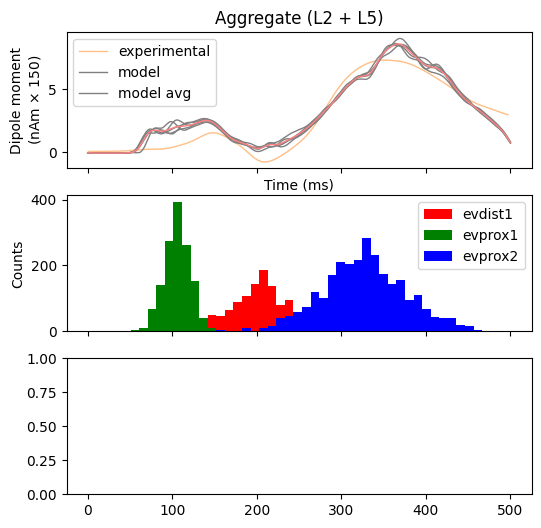

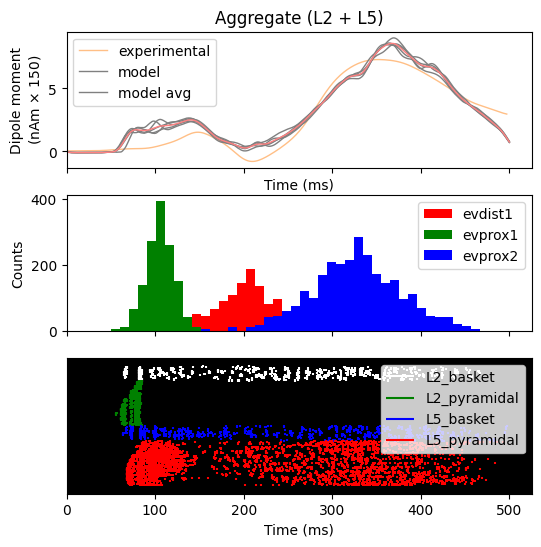

In [7]:
# visualize model output with the ERP
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6, 6))

exp_FS.plot(ax=axes[0], layer='agg', show=False, color='tab:orange')
plot_dipole(FS_dpls, ax=axes[0], layer='agg', show=False)
plot_dipole(average_dipoles(FS_dpls), ax=axes[0], layer='agg', show=False, color='red')
axes[0].legend(['experimental', 'model', 'model avg'])
FS_net.cell_response.plot_spikes_hist(ax=axes[1])
FS_net.cell_response.plot_spikes_raster(ax=axes[2])

There are some differences compared to the failed Stop model from the Diesburg et al. paper, which is not suprising because the Law model additions have changed the network connectivity and the model's behavior. We need to fit it to the FS ERP to get the correct set of parameters for the new model version.

In [13]:
# [copy your model-fitting code over and edit, start from the Diesburg et al. FS params above]
# all drive params can be optimized, but keep synaptic weights within 300% of the Jones default model params

In [ ]:
# produces behavior we would expect with beta ev?
